In [461]:
# python
import os, sys, pickle
from collections import OrderedDict
from itertools import combinations_with_replacement

# stats
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from scipy.stats import pearsonr, spearmanr


# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

# thesis library
from lib.functions_base_analysis        import *
from lib.functions_second_analysis      import *
from lib.ImageDataset                   import ImageDataset
from lib.NetworkScorer                  import NetworkScorer
from lib.PatternGenerator               import Pattern_Generator
from lib.ActivationPattern              import Activation_Pattern
from lib.transforms                     import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight    import PatternGeneratorSearchlight

DATASET_NAMES               = ('places1', 'places2', 'oasis')
SCALE_NAMES                 = ('scale2','scale4','scale8','scale16','scale32')
STUDY_NAMES                 = ("short presentation", "long presentation", "complexity order")
BEHAVIOUR_NAMES             = ('study1_places1_short.csv','study2_places1.csv','study3_places2.csv','study4_oasis.csv')

PATH_IMAGES                 = '../images and ratings/imageversions_256'
PATH_RATINGS                = '../images and ratings/ratings'
PATH_INTEGRATION     = '../data csv/integration' # !! correlations, invert sign for integration
PATH_INTEGRATION_BLOCKED     = '../data csv/integration blocked' # !! correlations, invert sign for integration
PATH_IB_CORRELATIONS        = '../data csv/ibcorr'
PATH_IB_CORRELATIONS_BLOCKED= '../data csv/ibcorr blocked'

PATH_RESULTS                = '../results'
PATH_PLOTS                  = '../plots'

#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

In [4]:
#DATA_PATH = './data_256x256'
#BEHAVIOR_PATH = './behavior'
#RESULTS_PATH = './data_integration_taskonomy'

# create folder structure

In [ ]:
# create folder structure for imageversions
for dataset_name in DATASET_NAMES:
    for scale_name in SCALE_NAMES:
        for version_name in ('full','version1','version2'):
            os.makedirs(os.path.join(PATH_IMAGES, dataset_name, scale_name, version_name))

## data csv

In [462]:
# integration
for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:
            dir_path = os.path.join(PATH_INTEGRATION_BLOCKED, model_name, dataset_name, scale_name)
            os.makedirs(dir_path)

In [ ]:
# ibcorr
STUDY_NAMES = ('short presentation','long presentation','complexity order','oasis')

for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            os.makedirs(os.path.join(PATH, model_name, study_name, scale_name))


## data mat

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'ibcorr', model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'ibcorr blocked', model_name))

In [488]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'ibcorr blocked_integr', model_name))

In [484]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'integration', model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../data mat', 'integration blocked', model_name))

# main analysis: part-whole correlations taskonomy 

In [ ]:
for model_name in MODEL_NAMES:
    print(model_name)

    # Import taskonomy model...
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]
    
    # ...and create activation extractor from it
    _, eval_nodes = get_graph_node_names(net)
    return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)


    for dataset_name in DATASET_NAMES:
        print(dataset_name)

        for scale_name in SCALE_NAMES:
            
            dataset = ImageDataset(
                os.path.join(PATH_IMAGES, dataset_name, scale_name))
                        
            correlations, selfsimilarity, l2norm = calculate_dataset_metrics(dataset, activation_extractor)
            
            correlations.fillna(correlations.mean())
            selfsimilarity.fillna(selfsimilarity.mean())
            l2norm.fillna(l2norm.mean())
            
            correlations.to_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'correlations.csv'), index=False, header=False)
            selfsimilarity.to_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            l2norm.to_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# integration
load & block

## load

In [485]:
# load integration, selfsim and l2norm
cl, sl, nl = [],[],[]


for mo in MODEL_NAMES:
    for da in DATASET_NAMES:
        for sc in SCALE_NAMES:

            c = pd.read_csv(os.path.join(PATH_INTEGRATION, mo, da, sc, 'correlations.csv'), header=None)
            c.insert(0, 'scale', sc)
            c.insert(0, 'dataset',da)
            c.insert(0, 'model', mo)
            cl.append(c)

            s = pd.read_csv(os.path.join(PATH_INTEGRATION, mo, da, sc, 'selfsimilarity.csv'), header=None)
            s.insert(0, 'scale', sc)
            s.insert(0, 'dataset',da)
            s.insert(0, 'model', mo)
            sl.append(s)
            
            n = pd.read_csv(os.path.join(PATH_INTEGRATION, mo, da, sc, 'l2norm.csv'), header=None)
            n.insert(0, 'scale', sc)
            n.insert(0, 'dataset',da)
            n.insert(0, 'model', mo)
            nl.append(n)
# convert correlation to integration
#df = -pd.concat(data_list).set_index(['model','dataset','scale'])

# don't convert correlation to integration
dfc = pd.concat(cl).set_index(['model','dataset','scale'])
dfs = pd.concat(sl).set_index(['model','dataset','scale'])
dfn = pd.concat(nl).set_index(['model','dataset','scale'])


## block
block layers accoring to vgg50 inherent blocks

In [486]:
dfc_blocked = (dfc
      .T
      .set_index(np.insert(np.repeat(range(2,17+1), 3),0,1))
      .T
      .groupby(level=0,axis=1).mean()
      .sort_index())

dfs_blocked = (dfs
      .T
      .set_index(np.insert(np.repeat(range(2,17+1), 3),0,1))
      .T
      .groupby(level=0,axis=1).mean()
      .sort_index())

dfn_blocked = (dfn
      .T
      .set_index(np.insert(np.repeat(range(2,17+1), 3),0,1))
      .T
      .groupby(level=0,axis=1).mean()
      .sort_index())

dfc_blocked

1         2         3         4   \
model           dataset scale                                             
autoencoding    oasis   scale16  0.999972  0.930246  0.898487  0.888570   
                        scale16  0.999983  0.891282  0.834662  0.836817   
                        scale16  0.999993  0.919629  0.884942  0.876619   
                        scale16  0.999988  0.915513  0.889436  0.881262   
                        scale16  0.999971  0.936975  0.910840  0.909143   
...                                   ...       ...       ...       ...   
vanishing_point places2 scale8   0.999972  0.843961  0.766262  0.723594   
                        scale8   0.999983  0.790177  0.696927  0.574517   
                        scale8   0.999956  0.846499  0.715647  0.607650   
                        scale8   0.999954  0.863559  0.788636  0.740657   
                        scale8   0.999984  0.797357  0.658857  0.525742   

                                       5         6         7         8   \
model           dataset scale                                             
autoencoding    oasis   scale16  0.898665  0.896763  0.857973  0.870503   
                        scale16  0.879502  0.843207  0.801369  0.747532   
                        scale16  0.868585  0.853618  0.814978  0.787349   
                        scale16  0.881615  0.881052  0.849210  0.830482   
                        scale16  0.915009  0.916806  0.884061  0.905494   
...                                   ...       ...       ...       ...   
vanishing_point places2 scale8   0.666034  0.633198  0.611525  0.606060   
                        scale8   0.522259  0.394640  0.376977  0.422398   
                        scale8   0.542072  0.445922  0.431017  0.448402   
                        scale8   0.656318  0.623057  0.633528  0.628451   
                        scale8   0.496187  0.370120  0.346389  0.388775   

                                       9         10        11        12  \
model           dataset scale                                             
autoencoding    oasis   scale16  0.899051  0.500165  0.343308  0.357115   
                        scale16  0.893263  0.706854  0.433166  0.568669   
                        scale16  0.865105  0.388069  0.220982  0.231470   
                        scale16  0.898696  0.384796  0.167690  0.132934   
                        scale16  0.914177  0.700498  0.505842  0.803112   
...                                   ...       ...       ...       ...   
vanishing_point places2 scale8   0.597981  0.608777  0.512532  0.637475   
                        scale8   0.399972  0.299345  0.432872  0.525194   
                        scale8   0.494212  0.738853  0.670367  0.757413   
                        scale8   0.633649  0.679350  0.705909  0.782766   
                        scale8   0.338413  0.695000  0.488276  0.637178   

                                       13        14        15        16  \
model           dataset scale                                             
autoencoding    oasis   scale16  0.294656  0.418697  0.741194  0.808153   
                        scale16  0.558399  0.770366  0.804050  0.761755   
                        scale16  0.239156  0.212392  0.304259  0.201446   
                        scale16  0.156950  0.150330  0.246027  0.131906   
                        scale16  0.539673  0.898768  0.917888  0.860223   
...                                   ...       ...       ...       ...   
vanishing_point places2 scale8   0.444788  0.474699  0.653336  0.576744   
                        scale8   0.314370  0.554472  0.622480  0.444402   
                        scale8   0.529272  0.659440  0.700878  0.557364   
                        scale8   0.402755  0.648674  0.762642  0.629577   
                        scale8   0.573487  0.577465  0.613915  0.444008   

                                       17  
model           dataset scale              
autoencoding    oasis   scale16  0.826386  
   

In [487]:
# save blocked integration, selfsim, l2norm
for m in MODEL_NAMES:
    for d in DATASET_NAMES:
        for sc in SCALE_NAMES:
            dfc_blocked.loc[(m, d, sc),:].to_csv(os.path.join(PATH_INTEGRATION_BLOCKED, m, d, sc, 'correlations.csv'), index=False, header=False)
            dfs_blocked.loc[(m, d, sc),:].to_csv(os.path.join(PATH_INTEGRATION_BLOCKED, m, d, sc, 'selfsimilarity.csv'), index=False, header=False)
            dfn_blocked.loc[(m, d, sc),:].to_csv(os.path.join(PATH_INTEGRATION_BLOCKED, m, d, sc, 'l2norm.csv'), index=False, header=False)

## visualize

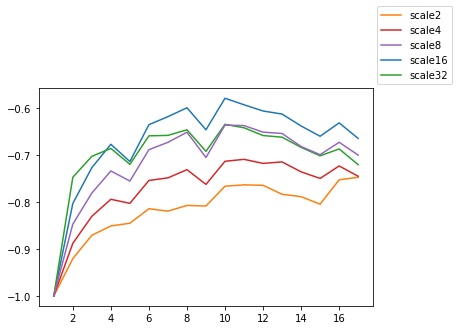

In [459]:
handles, labels = df.groupby('scale').mean().transpose().plot().get_legend_handles_labels()
order = [1, 3, 4, 0, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.25, 1.4))

# ibcorr & pvalues
load & block

In [ ]:
#ib_list, ss_list, ibss_list = [],[],[]
ib_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            ib = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlations.csv'), header=None).transpose()
            ib.insert(0, 'scale', scale_name)
            ib.insert(0, 'study',study_name)
            ib.insert(0, 'model', model_name)
            ib_list.append(ib)
            # ss = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'self_similarity.csv'), header=None).transpose()
            # ss.insert(0, 'scale', scale_name)
            # ss.insert(0, 'study',study_name)
            # ss.insert(0, 'model', model_name)
            # ss_list.append(ss)
            # ibss = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlation_ss_partialed.csv'), header=None).transpose()
            # ibss.insert(0, 'scale', scale_name)
            # ibss.insert(0, 'study',study_name)
            # ibss.insert(0, 'model', model_name)
            # ibss_list.append(ibss)
df_ib = pd.concat(ib_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
# ss_df = pd.concat(ss_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
# ibss_df = pd.concat(ibss_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)

In [ ]:
data_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            data = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlations_pvalues.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)
            data_list.append(data)
# layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr pvalue"}) for data in data_list]
# combine into one DataFrame
df_p = (pd.concat(data_list)
        .reset_index(drop=True)
        .set_index(['model','study','scale','layer'])
        .unstack('layer'))

# scale selection and blocking

## scale selection

In [394]:
# plot only significant pixels, bonferroni MCC
adjusted_pvalue = 0.05/49
df_ib_sig = df_ib.copy()
df_ib_sig.iloc[(df_p > adjusted_pvalue).values] = np.nan

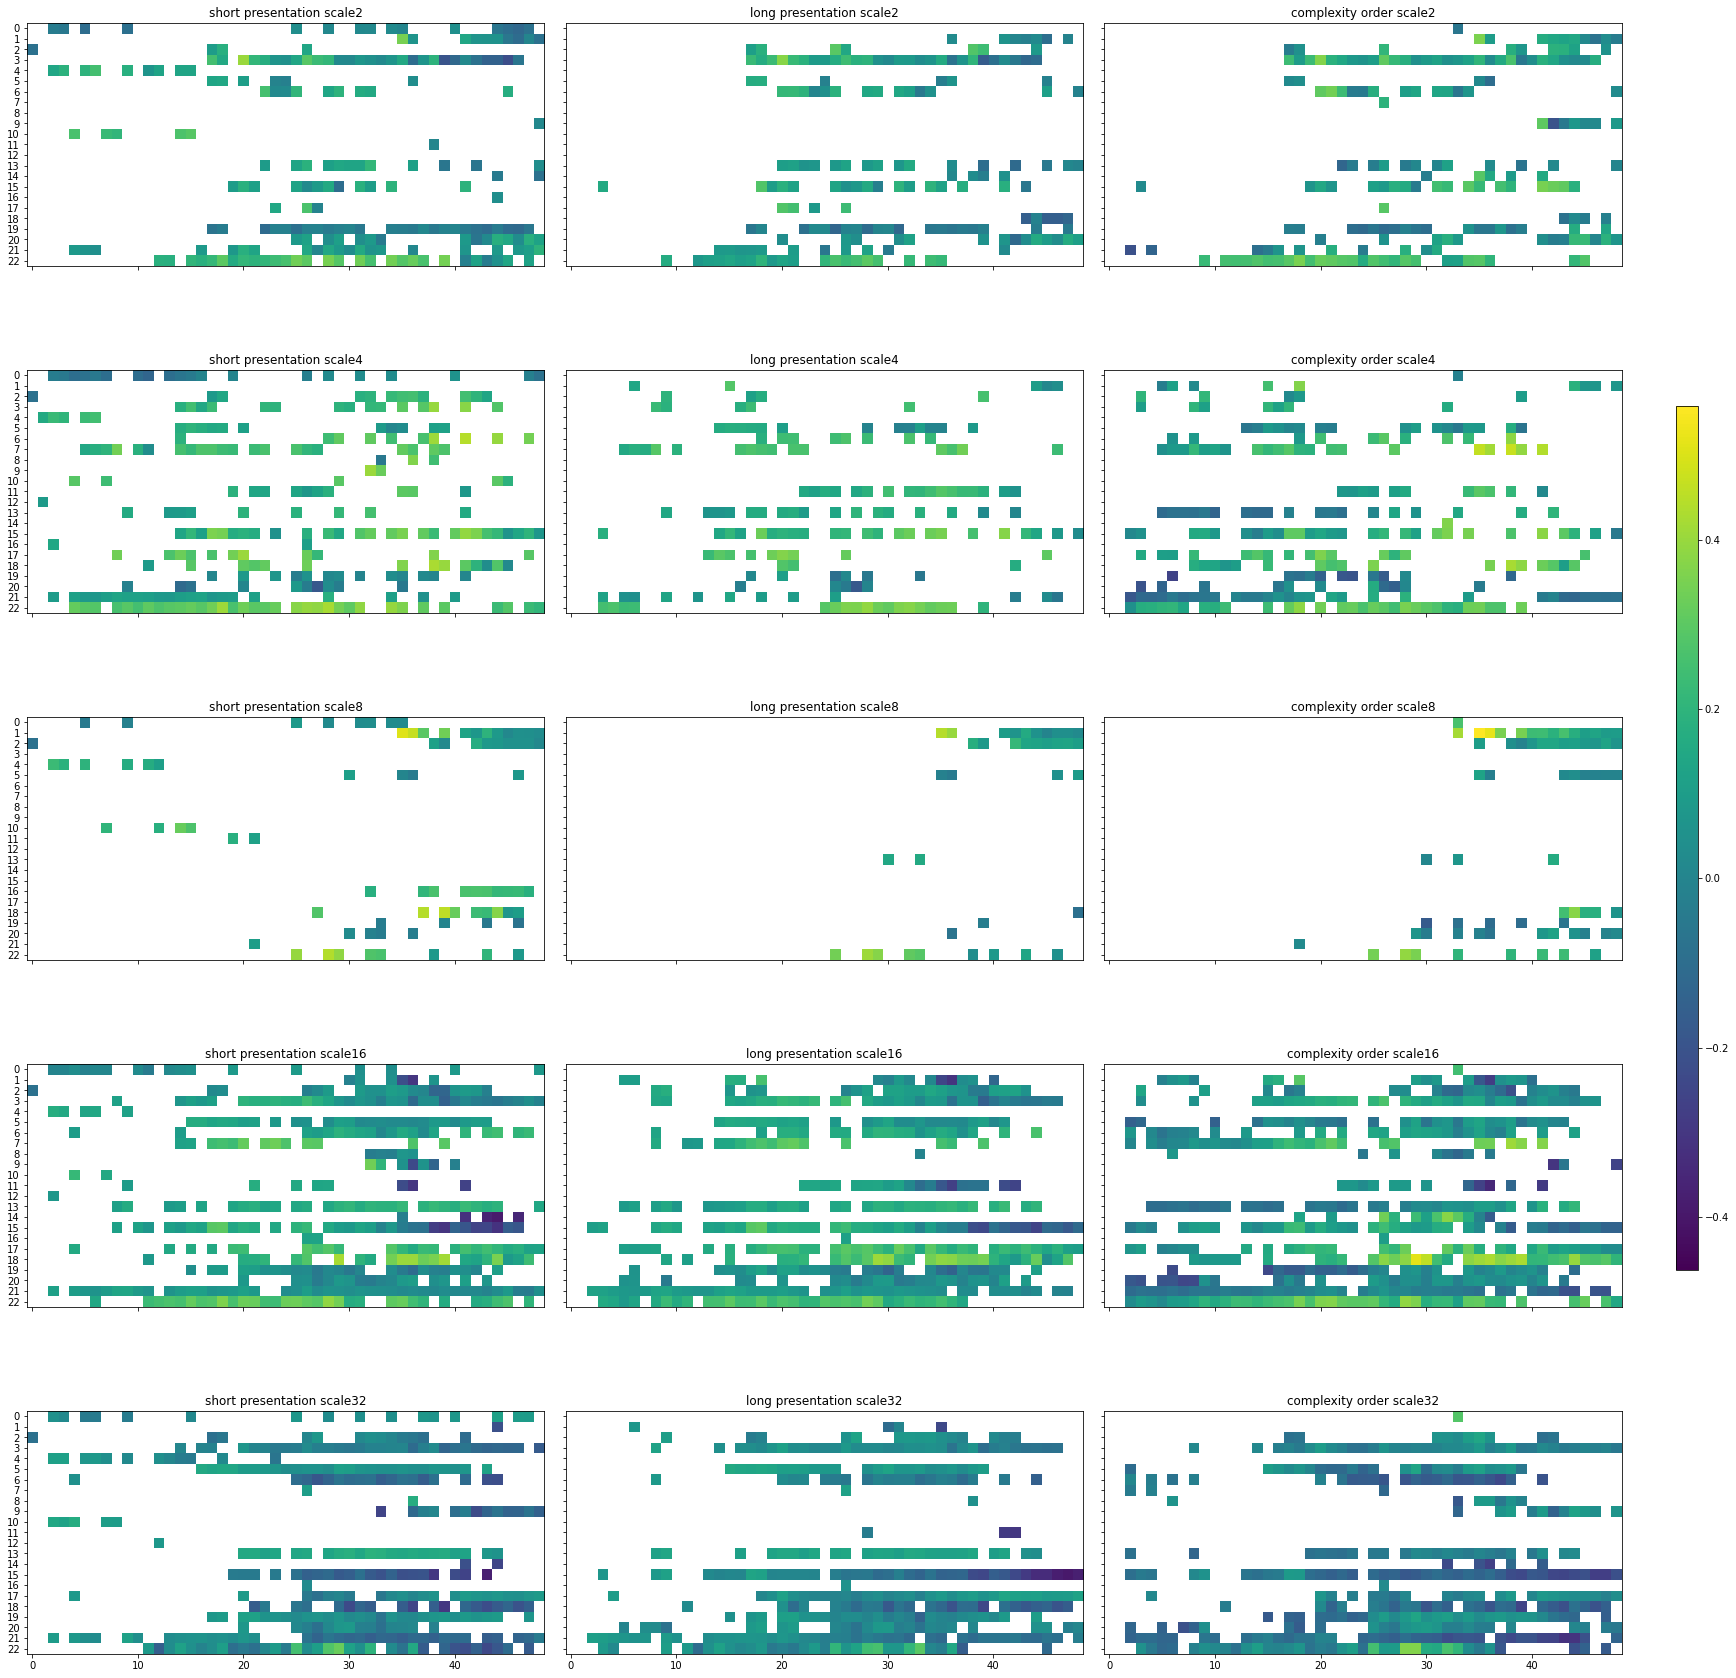

In [395]:
# scale x study grid of all-net heatmaps
fig, axes = plt.subplots(5, 3, figsize=(24,24), sharex=True,sharey=True, constrained_layout=True)

for idsc, scale in enumerate(SCALE_NAMES):
    for idst, study in enumerate(STUDY_NAMES):
        corr= df_ib_sig.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
        p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])

        ax = axes[idsc,idst]
        im = ax.imshow(corr, vmin=df_ib.min().min(), vmax=df_ib.max().max())
        #ax.contour(p, levels=[0.05], colors='orange', linewidths=5, corner_mask = False)

        ax.set_yticks(range(len(corr.index)))
        #ax.set_yticklabels(corr.index)
        ax.set_title(study + ' ' + scale)

fig.colorbar(im, ax =axes,orientation='vertical', fraction=.2, pad=0.03, shrink=.5)
#plt.subplots_adjust(hspace=0.2, wspace=.005)
#plt.tight_layout()

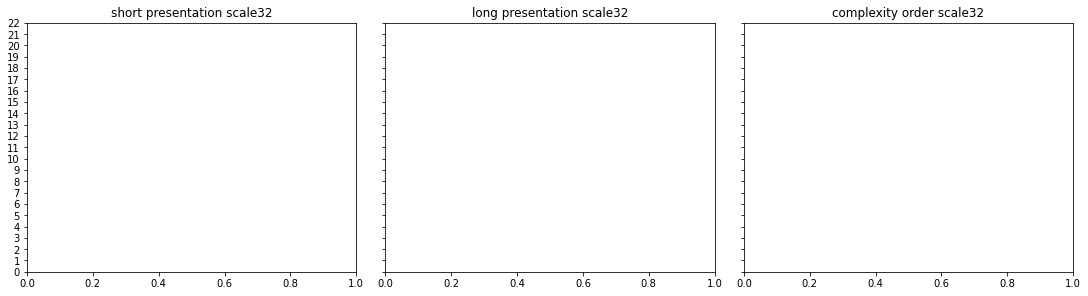

In [405]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True,sharey=True, constrained_layout=True)


for idst, study in enumerate(STUDY_NAMES):
    corr= df_ib.loc[(slice(None),study, 'scale16'),:].droplevel(['scale','study'])
    p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
    ax = axes[idst]
    
    ax.set_yticks(range(len(corr.index)))
    #ax.set_yticklabels(corr.index)
    ax.set_title(study + ' ' + scale)



## blocking layers

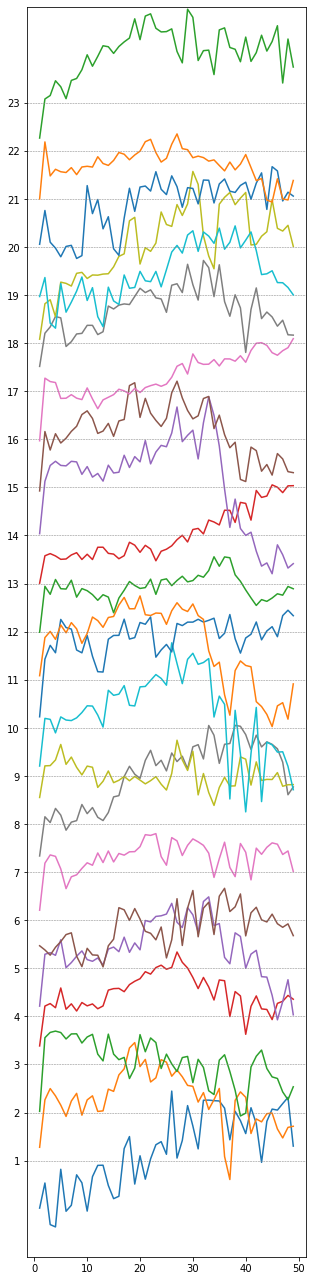

In [455]:
# unblocked view of scale16

tmp = df_ib.loc[(slice(None),study, 'scale16'),:]

fig, ax = plt.subplots(figsize=(5,23))


# for idst, study in enumerate(STUDY_NAMES):
#     corr= df_ib.loc[(slice(None),study, 'scale16'),:].droplevel(['scale','study'])
#     p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
#     ax = axes[idst]
    
#     ax.set_yticks(range(len(corr.index)))
#     #ax.set_yticklabels(corr.index)
#     ax.set_title(study + ' ' + scale)

for y,model in enumerate(MODEL_NAMES):
    ax.plot(10*tmp.iloc[y,slice(None)]+2*y+1)
    ax.axhline(y=2*y+1, color='grey', linestyle='--', linewidth=0.5)

ax.set_ylim(-3, 23*2+3)
ax.set_yticks(range(1,23*2,2));
ax.set_yticklabels(range(1,23+1));

# Plot each line with its offset
# ax.plot(x, y1, label='sin(x)')
# ax.plot(x, y2_offset, label=f'cos(x) + {offset}')
# ax.plot(x, y3_offset, label=f'exp(x/10) + {2 * offset}')

# # Optionally, add horizontal lines to indicate the offset
# ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=offset, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=2 * offset, color='grey', linestyle='--', linewidth=0.5)

# # Add legends, labels, and title
# ax.legend()
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_title('Multiple Lines with Y-Offset')

# # Show the plot
# plt.show()


## heatmapping testing

In [145]:
data = np.pad(np.random.random((10, 10)), 1)
data.shape

(12, 12)

In [180]:
data = np.random.random((10, 10))

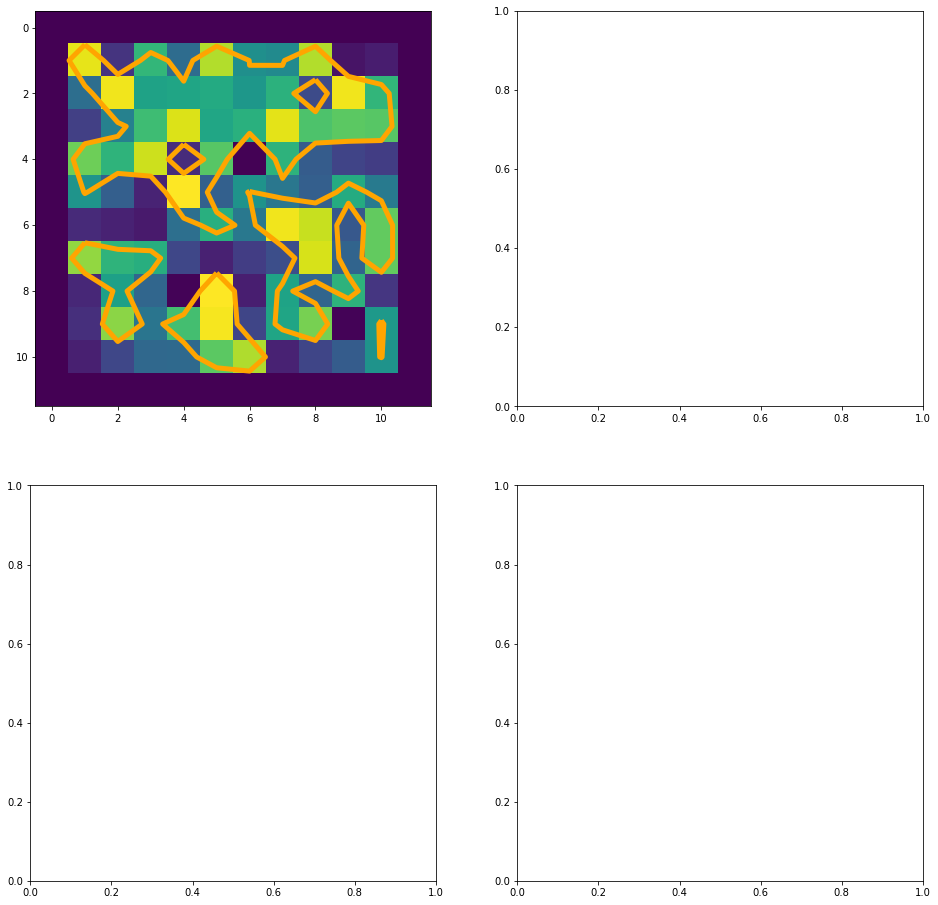

In [209]:
#data = np.pad(np.random.random((10, 10)), 1)
fig, ax = plt.subplots(2,2, figsize = (16,16))

# Example significance mask (True for significant, False for not)
# Let's assume that any value greater than 0.8 is significant
significance_mask = data > 0.8

# Plotting the heatmap
ax[0,0].imshow(data, cmap='viridis')

# Overlay the contours for significance
ax[0,0].contour(data, levels=[.5], colors='orange', linewidths=5, corner_mask = False)

# Add colorbar
#plt.colorbar()

# Show the plot
plt.show()


# import blocked data

In [ ]:
# load blocked integration correlation
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(DATA_PATH, model_name, study_name, scale_name, 'ib_correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr"}) for data in data_list]

# combine into one DataFrame
dfc = pd.concat(data_list).reset_index(drop=True).set_index(['model','study','scale','layer'])
dfc

In [ ]:
# load blocked integration 
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(DATA_PATH, model_name, study_name, scale_name, 'ib_correlations_pvalues.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr pvalue"}) for data in data_list]

# combine into one DataFrame
dfp = pd.concat(data_list).reset_index(drop=True).set_index(['model','study','scale','layer'])
dfp